In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/scratch/network/cs9095/cs551/eQTL_data/eQTL_joint.tsv.gz", sep="\t")
genes = pd.read_csv("/scratch/network/cs9095/cs551/GWAS_data/ENSEMBL_genes.tsv").ENSEMBL.to_list()

In [3]:
blist, plist, slist = [], [], []
for i in range(15):
    blist.append(f"beta_{i}")
    plist.append(f"pvalue_{i}")  
    slist.append(f"SE_{i}")
    
tlist = []
for i in range(15):
    tlist.append([f"beta_{i}", f"SE_{i}", f"pvalue_{i}"])

In [103]:
df.loc[df.gene_id == "ENSG00000000419"]

,gene_id,variant_id,beta_0,SE_0,pvalue_0,beta_1,SE_1,pvalue_1,beta_2,SE_2,...,pvalue_11,beta_12,SE_12,pvalue_12,beta_13,SE_13,pvalue_13,beta_14,SE_14,pvalue_14
0,ENSG00000000419,chr20_49959212_C_T,-0.056097,0.094067,0.551434,0.171158,0.125365,0.173364,0.187151,0.085632,...,0.621105,-0.005981,0.090768,0.947486,0.011533,0.092457,0.900798,0.031668,0.107414,0.768728
1,ENSG00000000419,chr20_49959775_T_A,-0.012144,0.045403,0.789308,-0.005738,0.061263,0.925454,-0.007822,0.050163,...,0.219696,-0.054835,0.053129,0.302469,-0.020221,0.053015,0.703111,-0.013392,0.062197,0.829945
2,ENSG00000000419,chr20_49959987_G_A,0.065057,0.170754,0.703503,0.061489,0.244183,0.801387,-0.040294,0.101483,...,0.509849,-0.055084,0.111523,0.621551,-0.009468,0.105965,0.928851,0.169837,0.174749,0.333403
3,ENSG00000000419,chr20_49960491_C_CAT,0.075879,0.058996,0.199473,-0.046287,0.080669,0.566616,-0.049779,0.051649,...,0.646677,0.060752,0.054993,0.269753,-0.012179,0.057337,0.831911,0.024519,0.063460,0.700020
4,ENSG00000000419,chr20_49960606_A_G,-0.008241,0.046036,0.858055,-0.023129,0.061512,0.707225,0.003490,0.049350,...,0.493607,-0.065866,0.052396,0.209249,-0.017773,0.052667,0.735968,-0.013936,0.062043,0.822730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5328,ENSG00000000419,chr20_51957082_T_C,-0.014240,0.044537,0.749420,0.037798,0.061111,0.536789,-0.013934,0.048912,...,0.381503,-0.019518,0.054426,0.720014,0.055843,0.055382,0.313960,-0.172659,0.063008,0.007248
5329,ENSG00000000419,chr20_51958088_T_C,0.046430,0.052738,0.379422,-0.023004,0.073464,0.754435,0.025914,0.052812,...,0.093815,0.011090,0.055625,0.842050,-0.018954,0.053000,0.720826,-0.148226,0.069815,0.036162
5330,ENSG00000000419,chr20_51958473_AAAG_A,0.047439,0.053129,0.372691,-0.022412,0.074031,0.762334,0.023624,0.051739,...,0.144750,-0.001094,0.054538,0.983997,-0.002001,0.053602,0.970237,-0.131133,0.069555,0.062232
5331,ENSG00000000419,chr20_51958527_C_T,-0.010139,0.047010,0.829398,-0.026085,0.066361,0.694592,-0.043455,0.058054,...,0.964742,-0.056238,0.063884,0.379070,0.019921,0.068183,0.770328,-0.122964,0.072566,0.093220


In [4]:
# SNP filtering:

goi = []
signs = []
pvals = [0.001]
pvals = [0.1, 0.05, 0.01]

for p in pvals:
    g_temp = []
    s_temp = []

    for gene in genes:
        sub_df = df.loc[(df.gene_id == gene)]
        for beta, pval in zip(blist, plist):
            
            # 1 == positive, 2 == negative
            sub_df.loc[:,beta] = [1 if i else 2 for i in sub_df[beta].ge(0).tolist()] 
            # only take p-values less than 1e-3
            sub_df.loc[:,pval] = [int(i) for i in sub_df[pval].le(p).tolist()] 
            
        sub_df = sub_df.drop(columns=slist)
        sub_df = sub_df.reset_index()
    
        # baesd on pval element-wise erase non-signif.
        con = pd.DataFrame(sub_df[plist].to_numpy() * sub_df[blist].to_numpy())  
        con[["pos", "neg"]] = 0
        con.pos = con.isin([1]).sum(axis=1).tolist()
        con.neg = con.isin([2]).sum(axis=1).tolist()
        
        # take only if 3+ tissues agree in the same direction
        if np.sum(con.pos >= 3) > np.sum(con.neg >= 3): 
            ind = con[(con.pos >= 3)].index
            sign = 1
        else:
            ind = con[(con.neg >= 3)].index
            sign = -1
        if not sub_df.iloc[ind].empty:
            g_temp.append(gene)
            s_temp.append(sign)
    goi.append(g_temp)
    signs.append(s_temp)    

In [ ]:
# Does the confidence threshold alter the number of genes selected?
[len(i) for i in goi] 
# ^ [16, 16, 15]: Only in the last threshold drop

# Are the 16 genes in the 0.1 set and 0.05 set the same?
goi[0] == goi[1] 
# ^ True: the genes in 0.1 and 0.05 are identical

# Are the genes in the 0.01 set all in the 0.05 set?
[gene in goi[1] for gene in goi[2]] 
# ^ [True...True]: the genes in 0.01 are all in 0.05

# Which gene was droppped?
[gene for gene in goi[1] if (not gene in goi[2])] 
# ^ ENSG00000073792: insulin like growth factor 2 mRNA binding protein 2

In [38]:
# Setup confidence threshold analysis dataframe
total = pd.DataFrame()
for i, j, p in zip(goi, signs, pvals):
    oi = pd.DataFrame()
    oi["gene"] = [item for item in i]
    oi["sign"] = ["1" if item == 1 else "-1" for item in j]
    oi["sign"] = j
    oi["pval"] = str(p)
    total = pd.concat([total, oi])    

/home/cs9095/.conda/envs/csun/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


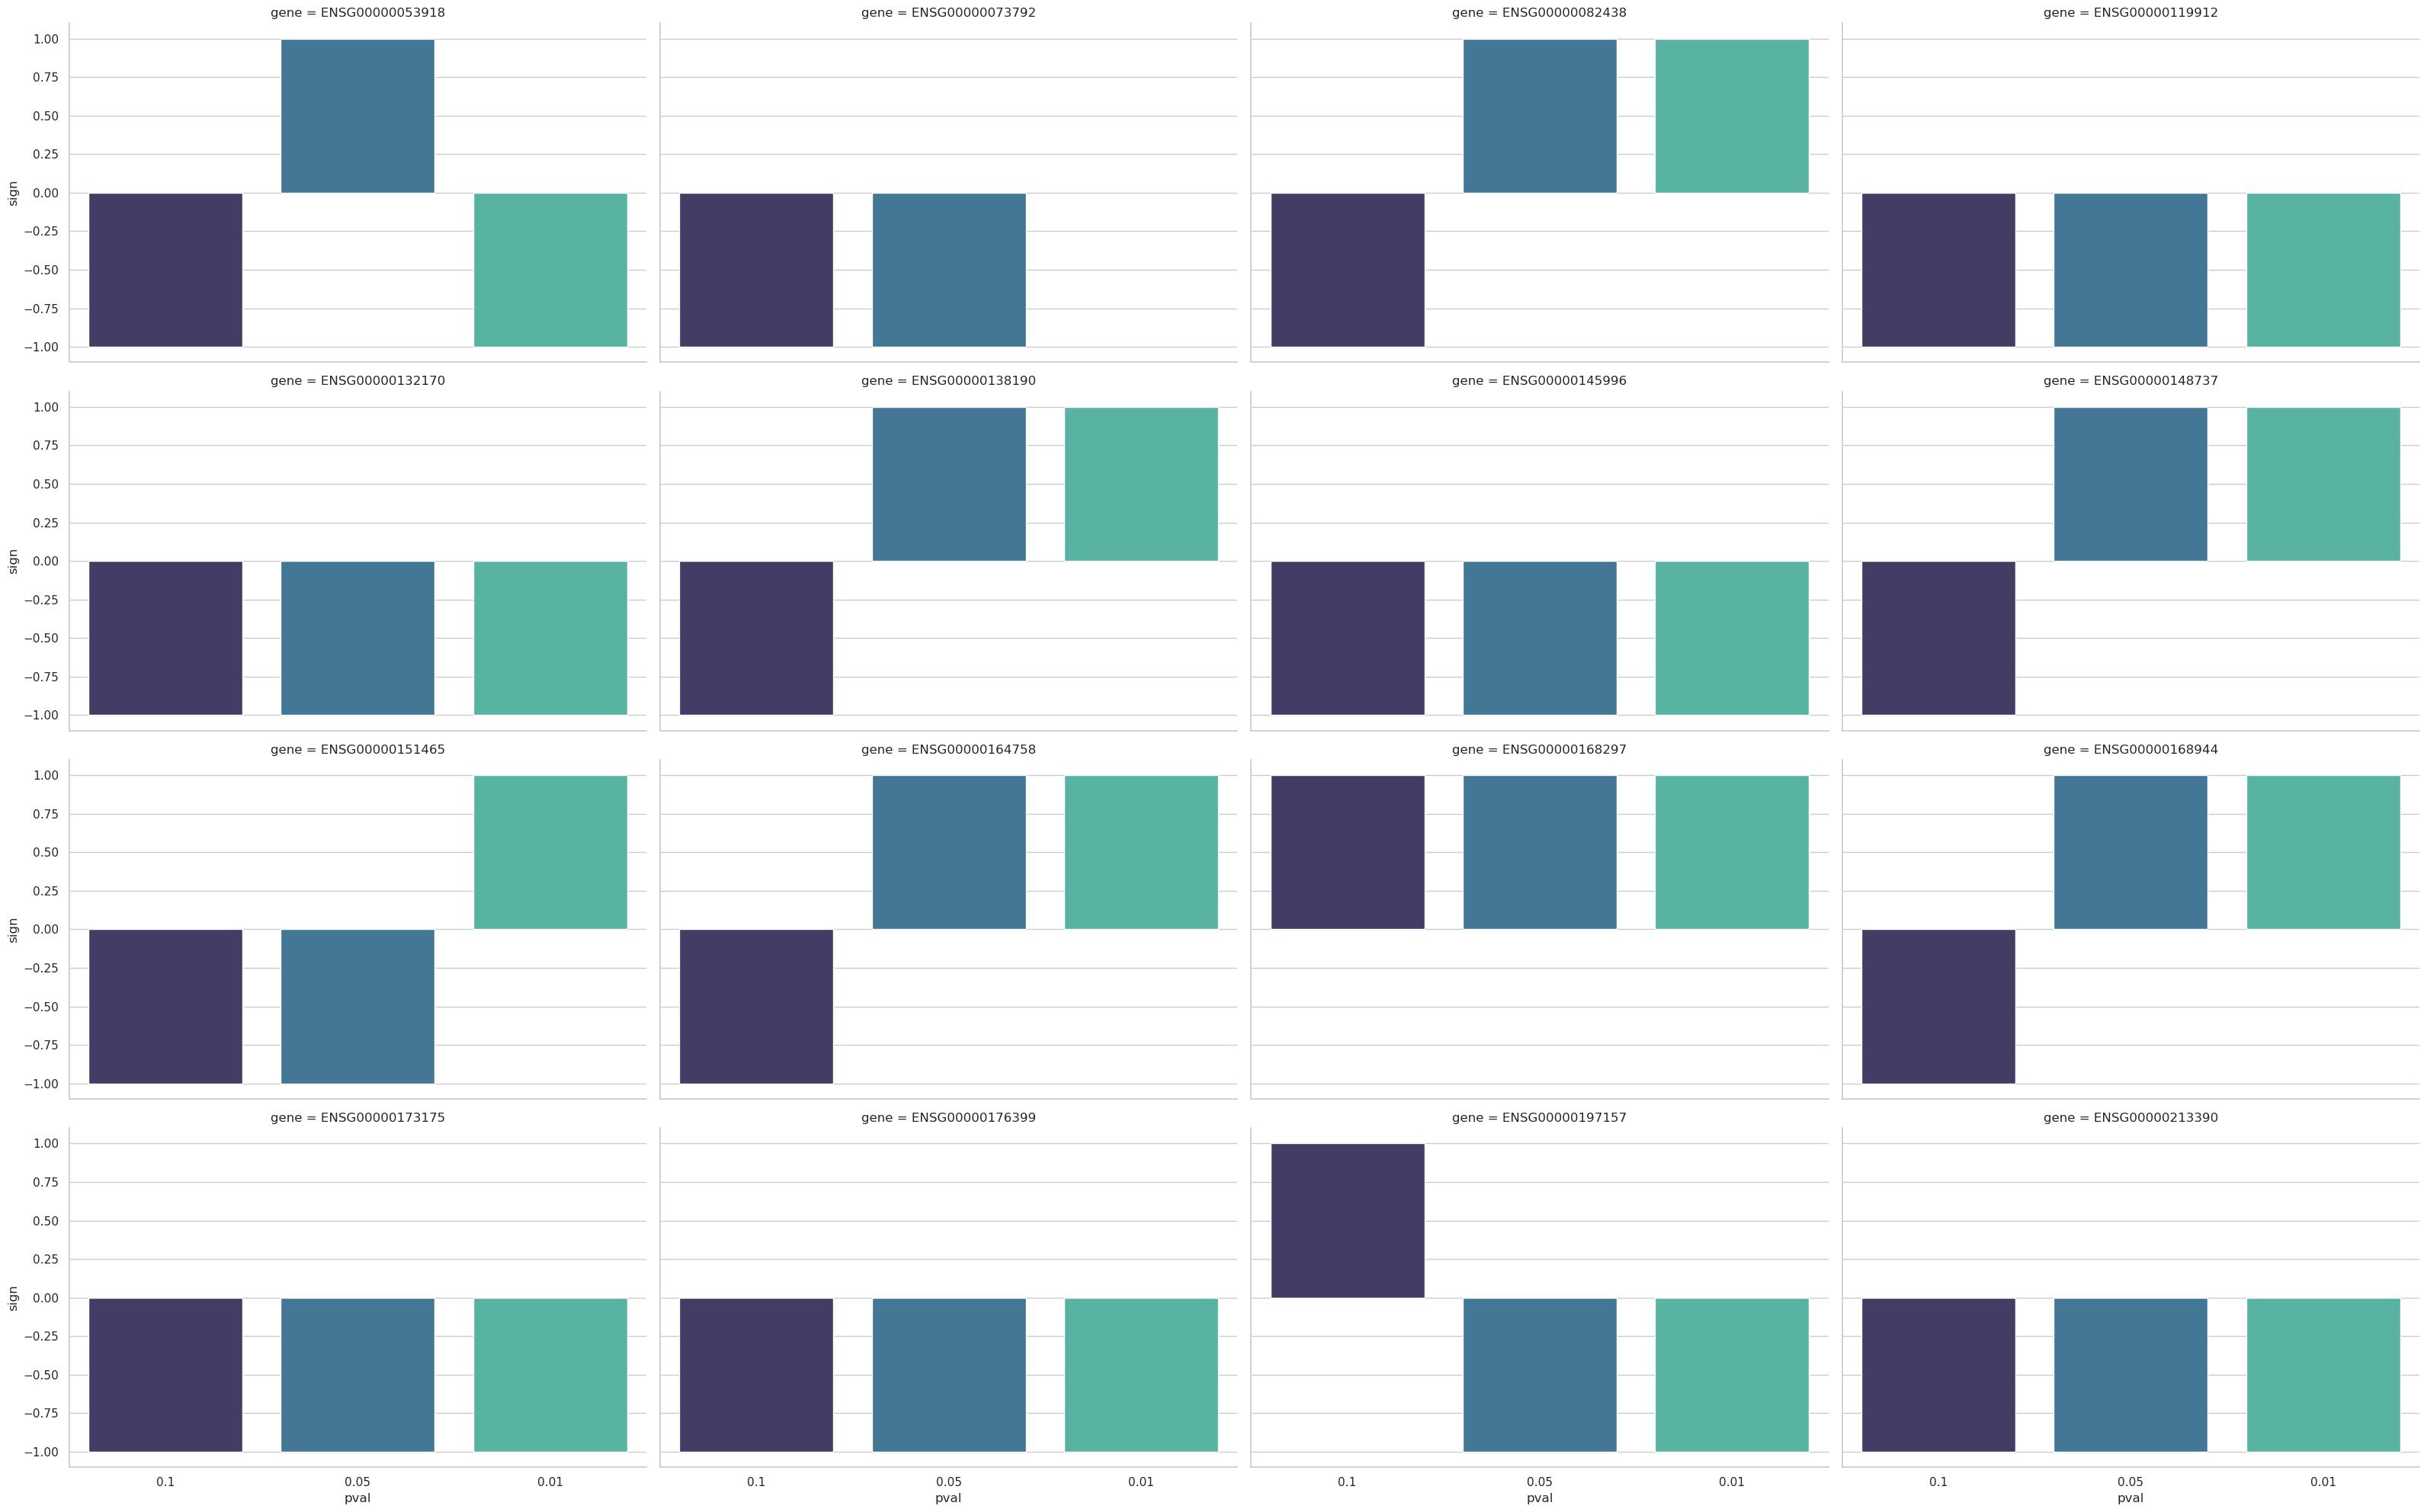

In [58]:

# for gene in total.gene.unique():
# sns.pointplot(data=total, x="pval", y="sign", palette="mako", ax=axes, hue="gene")
sns.catplot(
    data=total, col="gene", x="pval", y="sign", kind="bar",
    palette="mako", height=5, aspect=1.6, col_wrap=4)
plt.show()

In [80]:
total.gene = total.gene.str.replace("ENSG", "").astype(int).astype(str)

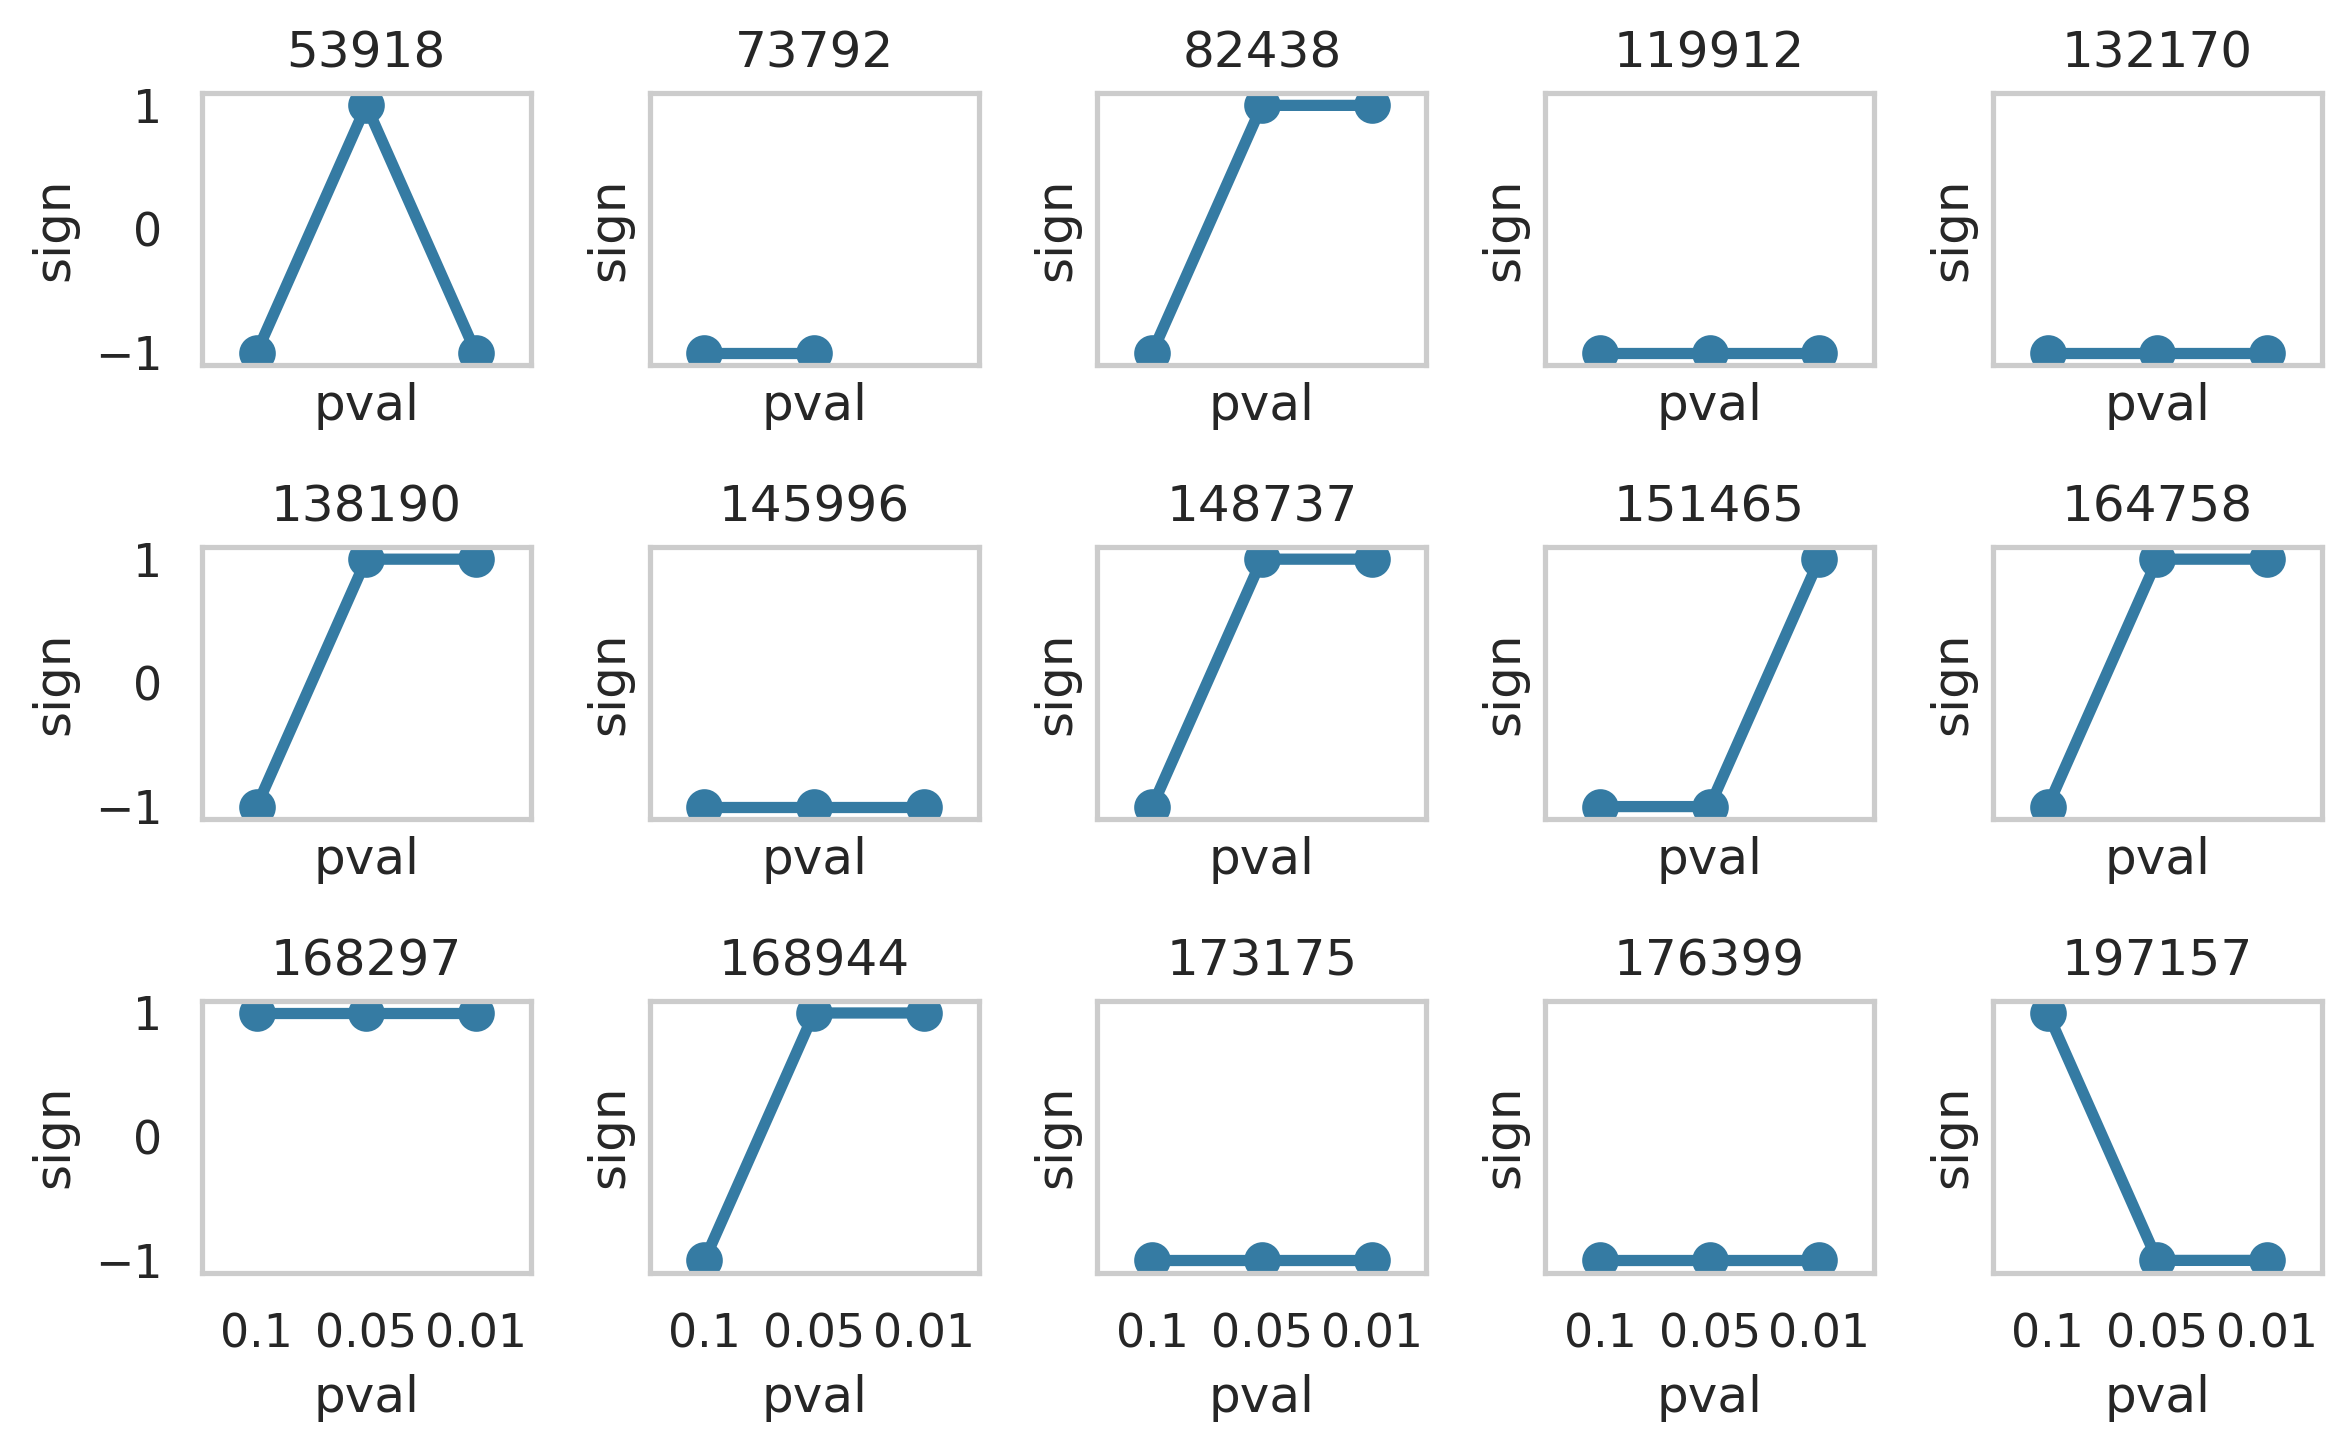

In [81]:
# Does the confidence threshold alter the consenus sign of signifcant betas? 
sns.set_style("whitegrid", {'axes.grid' : False})
fig, axes = plt.subplots(3,5, figsize=(8,5), dpi=300, 
                         sharey=True, sharex=True)
axes = np.ravel(axes)

for gene, ax in zip(total.gene.unique(), axes):
    g = sns.pointplot(data=total[total.gene == gene], x="pval", y="sign", hue="gene", 
                  palette="mako", ax=ax)
    g.legend_.remove()
    ax.title.set_text(gene)

# plt.savefig("/scratch/network/cs9095/cs551/figures/sign_changes.png")
plt.tight_layout()
plt.show()

---

In [1]:
# Plots of eQTL data for signficant Genes: 

# abs. beta , and neg. log of p_value
# large abs betas roughly correlated with signifcance
# however, discrepancies can be attributed ot differences in the mag of the est. SE
# this is accoutned for in our model, whihc is a weighted mix-effects model.
# this emphasies taking into accoutn estimatation uncertaintiyh in our model.

fig, axes = plt.subplots(len(goi),2,figsize=(15,50), dpi=100)
axes = np.ravel(axes)
    
for gene, a, b in zip(goi[2], axes[::2], axes[1::2]):
    at = pd.read_csv(f"/scratch/network/cs9095/cs551/eQTL_data/eQTL_genes/eQTL_{gene}.tsv.gz", sep="\t")
    at = at.drop(columns=["gene_id"])
    at = at.set_index(["variant_id"])
    sns.heatmap(data=at[blist].T.apply(np.absolute), ax=a, cmap="RdPu")
    sns.heatmap(data=at[plist].T.apply(np.log).apply(lambda x: x * -1), ax=b, cmap="RdPu")
    a.title.set_text(f'{gene} Betas')
    b.title.set_text(f'{gene} P-values')

plt.tight_layout()
# plt.savefig(f"/scratch/network/cs9095/cs551/figures/sum_{gene}_beta_pval.png")
plt.show()